## 각 셀을 실행시키면서 waveform에서 Mel spectrogram으로 변환되는 과정을 이해하시길 바랍니다.


## 음성 파일 다운로드

In [ ]:
import gdown
url = "https://drive.google.com/file/d/15Oc0D-BsyDQ3nQfM2203Qt4jbQ6DKXSA/view?usp=sharing"
output = 'sample.wav' # sample.wav 파일 다운로드
gdown.download(url,output,quiet=False)

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=15Oc0D-BsyDQ3nQfM2203Qt4jbQ6DKXSA
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/file/d/15Oc0D-BsyDQ3nQfM2203Qt4jbQ6DKXSA/view?usp=sharing
To: /content/sample.wav
73.5kB [00:00, 14.9MB/s]


'sample.wav'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
output = '/content/gdrive/My Drive/Audio/a2s/water/201165.wav'

In [ ]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt

FIG_SIZE = (15,10)

In [ ]:
from scipy import signal
# 음성 파일 load
sig, sr = librosa.load(output, sr=22050)


3.465173e-06 -0.36703384 24.438717


In [ ]:
##VGG
resamples = np.tile(sig,10)[:160000]

resamples[resamples > 1.] = 1.
resamples[resamples < -1.] = -1.
frequencies, times, spectrogram = signal.spectrogram(resamples, sr, nperseg=512,noverlap=353)
spectrogram = np.log(spectrogram+ 1e-7)
print(spectrogram.mean(),spectrogram.min(),spectrogram.max())
mean = np.mean(spectrogram)
std = np.std(spectrogram)
spectrogram = np.divide(spectrogram-mean,std+1e-9)
print(spectrogram.mean(),spectrogram.min(),spectrogram.max())

-16.063593 -16.118095 -12.434579
3.465173e-06 -0.36703384 24.438717


Text(0.5, 1.0, 'Waveform')

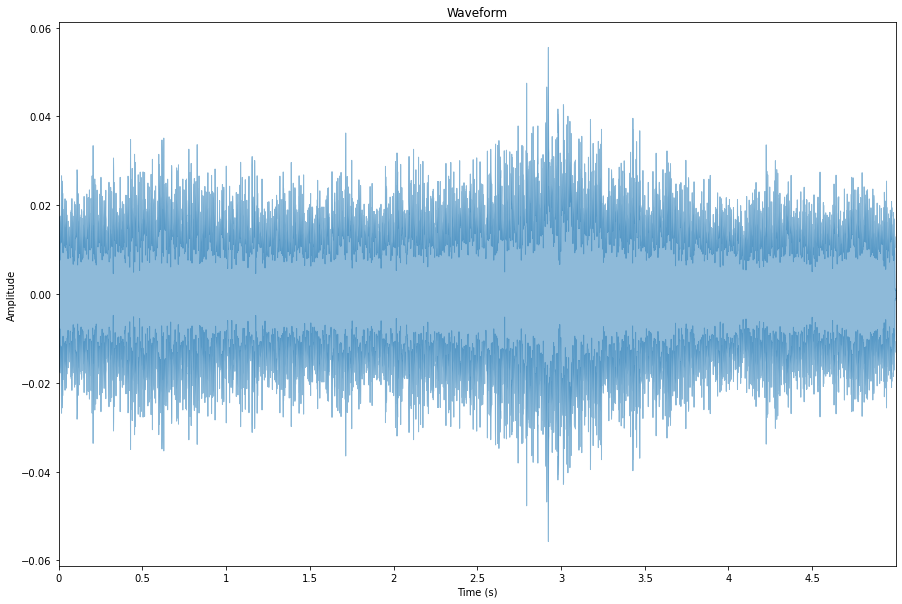

In [ ]:
plt.figure(figsize=FIG_SIZE)
librosa.display.waveplot(sig, sr, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

In [ ]:
from IPython.display import Audio
import torch.nn as nn
import torch.nn.functional as F
import torch
from librosa.filters import mel as librosa_mel_fn

Audio(data=sig, rate=sr)

In [ ]:
n_fft = 1024
hop_length = 256
win_length = 1024
sampling_rate = 22050
n_mel_channels = 80
mel_fmin = 0.0
mel_fmax=None
window = torch.hann_window(win_length).float()
mel_basis_ = librosa_mel_fn(
            sampling_rate, n_fft, n_mel_channels, mel_fmin, mel_fmax
        )
mel_basis = torch.from_numpy(mel_basis_).float()


y=torch.from_numpy(sig)
y=y[None,None]
p = (n_fft - hop_length) // 2
audio = F.pad(y, (p, p), "reflect").squeeze(1)
fft = torch.stft(
    audio,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    center=False,
)



real_part, imag_part = fft.unbind(-1)
magnitude = torch.sqrt(real_part ** 2 + imag_part ** 2)
mel_output = torch.matmul(mel_basis, magnitude)
log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
mel=log_mel_spec[0].numpy()
print(mel.shape, mel.min(),mel.max(),mel.mean())




mel_spectrogram = librosa.feature.melspectrogram(y=sig, sr=sr, n_mels=128, n_fft=n_fft,
                                                         hop_length=hop_length, win_length=win_length,
                                                         fmax=8000)
log_mel_spectrogram = np.log10(np.clip(mel_spectrogram, a_min=1e-5, a_max=None))
print(log_mel_spectrogram.shape, log_mel_spectrogram.min(),log_mel_spectrogram.max(),log_mel_spectrogram.mean())


(80, 430) -5.0 -0.79186165 -2.3421607
(128, 431) -5.0 -0.23931327 -2.96017


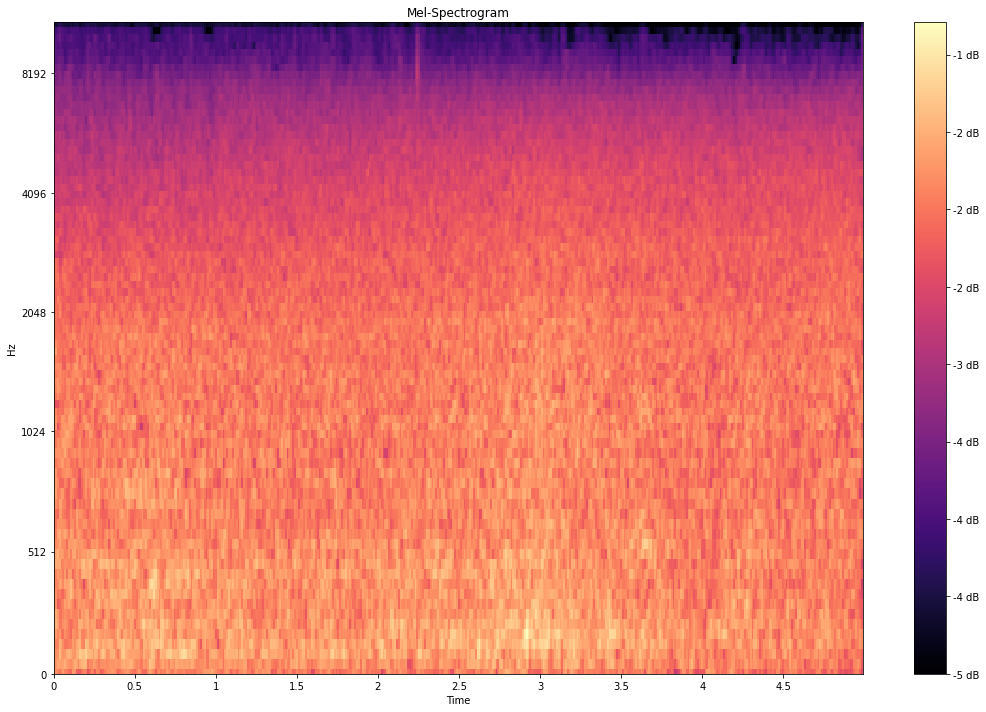

In [ ]:
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, y_axis='mel', sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

## 퓨리에 변환으로 스펙트럼 구하기

Text(0.5, 1.0, 'Power spectrum')

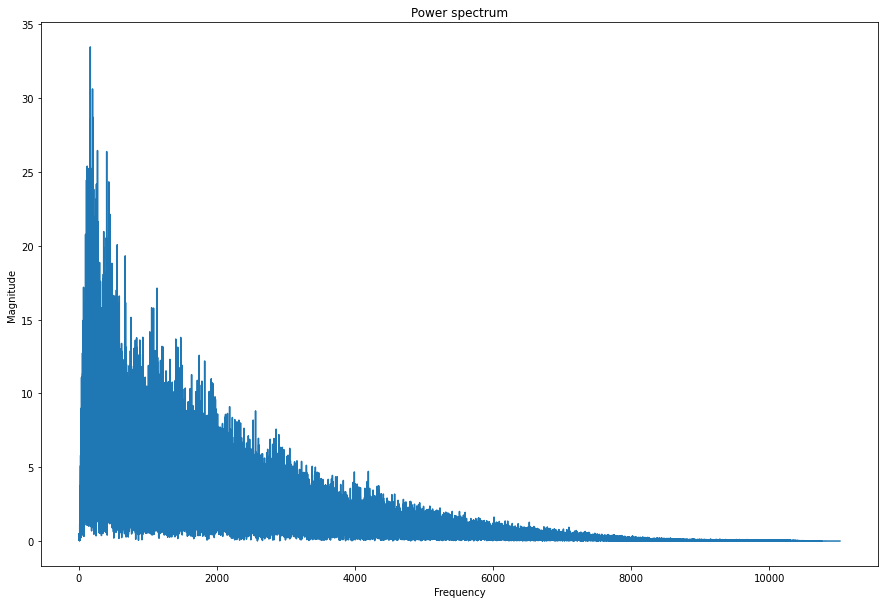

In [ ]:
# 단순 퓨리에 변환으로 스펙트럼 구하기
fft = np.fft.fft(sig)

# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

## STFT를 사용하여 Spectrogram 생성하기

Text(0.5, 1.0, 'Spectrogram (dB)')

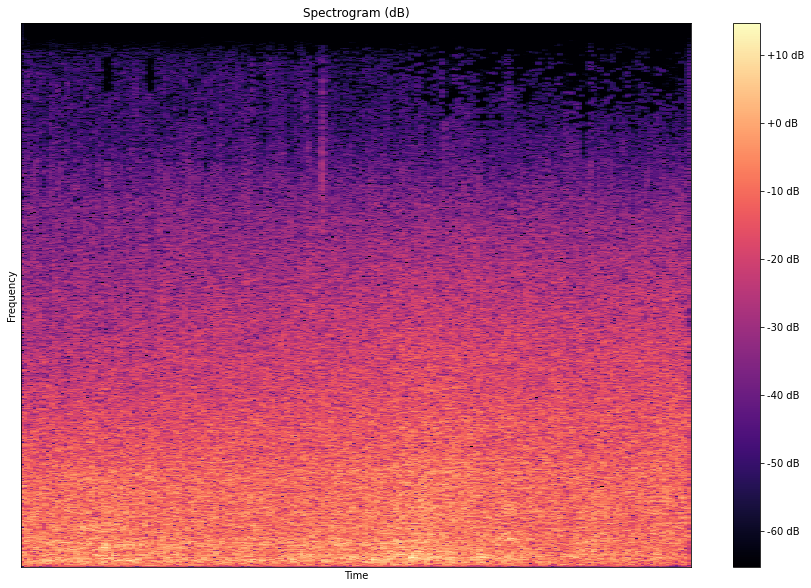

In [ ]:

# STFT를 사용하여 spectrogram 생성하기

hop_length = 512  # 전체 frame 수
n_fft = 2048  # frame 하나당 sample 수

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sr
n_fft_duration = float(n_fft)/sr

# STFT
stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)

# 복소공간 값 절댓값 취하기
magnitude = np.abs(stft)

# magnitude > Decibels 
log_spectrogram = librosa.amplitude_to_db(magnitude)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

## Mel-spectrogram 생성하기

(80, 216) 1e-08 0.71028227 0.42455205


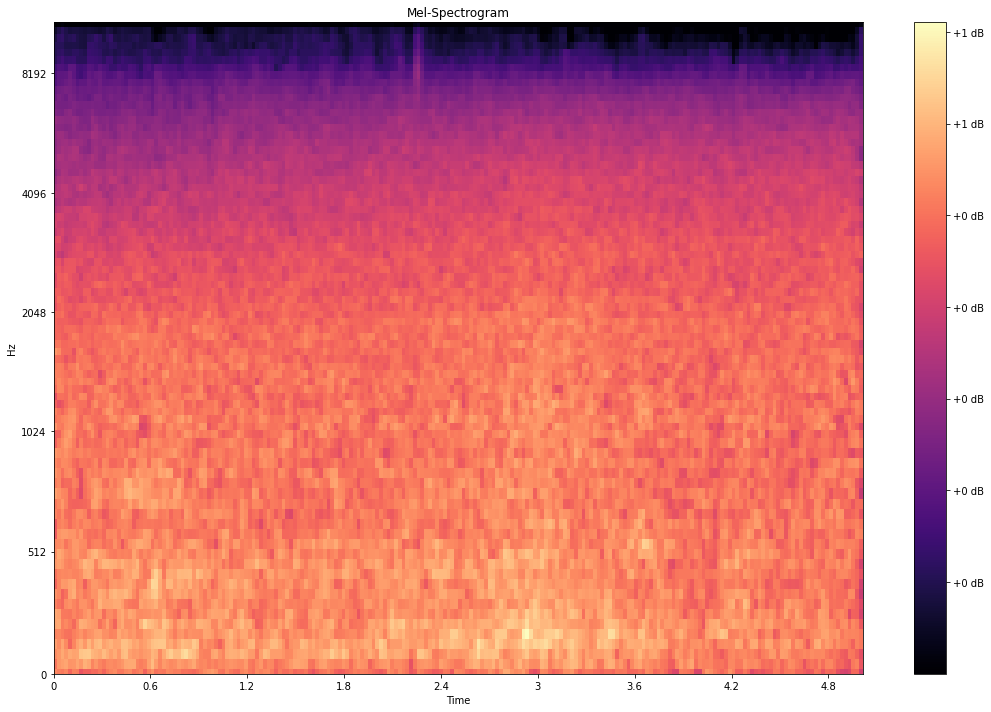

In [ ]:
# Mel spectrogram 생성하기
n_mels = 80

# mel spectrogram
mel_basis = librosa.filters.mel(sr, n_fft, n_mels)  # (n_mels, 1+n_fft//2)
mel = np.dot(mel_basis, magnitude)  # (n_mels, t)

# to decibel
mel = 20 * np.log10(np.maximum(1e-5, mel))

# normalize
mel = np.clip((mel - 20 + 100) / 100, 1e-8, 1)

print(mel.shape, mel.min(),mel.max(),mel.mean())

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel, y_axis='mel', sr=sr, hop_length=hop_length, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

## MFCC 확인

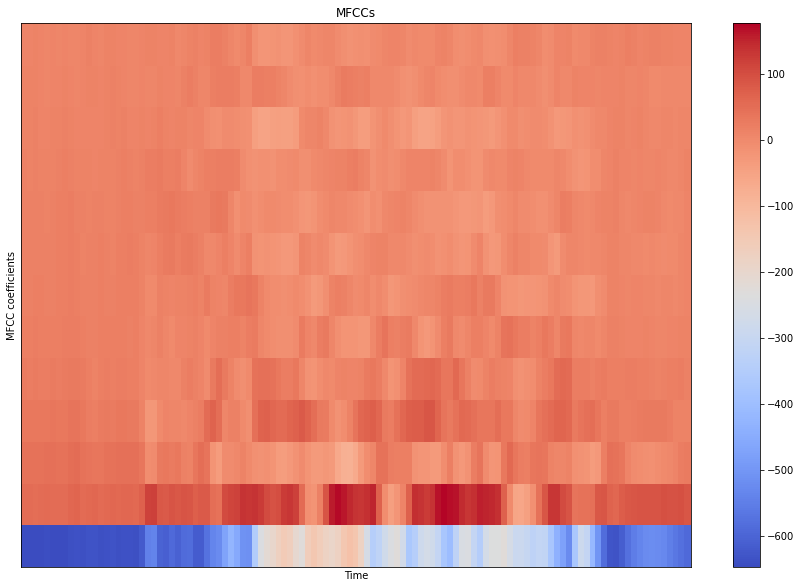

In [ ]:
# MFCCs

# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(sig, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()